我们用到的这个数据是英国在线零售数据。这个数据里涵盖了从2010年1月12号到2011年9月12号期间在英国注册的在线零售店发生的所有交易。该公司主要销售一些通用的节日礼品。该公司的许多客户都是批发商。

<p style='color:gold;fontsize:300%;font-weight:bold;'>
属性信息：
    InvoiceNo: 发票编号。标称值，6位整数。如果代码以字母“c”开头，则表示取消<br/>
    StockCode: 产品代码。标称值，为每个不同的产品唯一分配的5位整数<br/>
    Description: 产品名<br/>
    Quantity：产品数量<br/>
    InvoiceDate：发票日期<br/>
    UnitPrice：单价。英镑单位的产品价格<br/>
    CustomerID：客户编码<br/>
    Country：每个客户所在的国家<br/>
</p>

In [1]:
import datetime
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import skew,norm,probplot,boxcox
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

In [2]:
df_initial = pd.read_excel('Online Retail.xlsx',dtype={'CustomerID':str,'InvoiceNo':str})
df_initial.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

### EDA

In [3]:
# describe works for numerical data
df_eda = df_initial
df_eda.describe()

Quantity      UnitPrice
count  541909.000000  541909.000000
mean        9.552250       4.611114
std       218.081158      96.759853
min    -80995.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   38970.000000

In [4]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
print(f"data shpae:{df_eda.shape}")
df_eda['InvoiceDate'] = pd.to_datetime(df_eda['InvoiceDate'])
df_eda.head()

df_eda['CustomerID'].isnull().sum()     #检查空值数
tab_info = pd.DataFrame(df_eda.dtypes).T.rename(index={0:'column type'})     #对df_eds.dtypes(数据结构)转置并重命名
tab_info = tab_info.append(pd.DataFrame(df_eda.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_eda.isnull().sum()/df_eda.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)
display(df_eda[:5])

data shpae:(541909, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)          0         0    0.268311        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)          0    24.9267       0

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [6]:
df_eda.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [7]:
#统计非重复值(pandas)
def count_unique_value(df1):
    for i in df1.columns:
        count = df1[i].nunique()
        print(f'{i}:{count}')
count_unique_value(df_eda)

InvoiceNo:25900
StockCode:4070
Description:4223
Quantity:722
InvoiceDate:23260
UnitPrice:1630
CustomerID:4372
Country:38


In [8]:
##### 统计每个column的信息
def rstr(df,pred=None):     #pred=None 不考虑列的相关系数，如果定义为True则要考虑相关系数
    obs = df.shape[0]     #rows
    types = df.dtypes
    counts = df.apply(lambda x:x.count())
    unique = df.apply(lambda x:[x.unique()])
    nulls = df.apply(lambda x:x.isnull().sum())
    distincts = df.apply(lambda x:x.unique().shape[0])
    missing_ratio = (df.isnull().sum()/obs)*100
    skewness = df.skew()     #偏度（相对于正态分布）
    kurtosis = df.kurt()     #峰度
    print('Data shape:',df.shape)
    
    if pred is None:
        cols = ['types','counts','distincts','nulls','missing_ratio','skewness','kurtosis']
        str_s = pd.concat([types,counts,distincts,nulls,missing_ratio,skewness,kurtosis],axis=1,sort=True)
    else:
        corr = df.corr()[pred]
        str_s = pd.concat([types,counts,distincts,nulls,missing_ratio,skewness,kurtosis,corr],axis=1,sort=True)
        corr_col = 'corr ' + pred
        cols = ['types','counts','distincts','nulls','missing_ratio','skewness','kurtosis',corr_col]
        
    str_s.columns = cols
    dtypes = str_s.types.value_counts()
    print('_____________\n Data types:\n',str_s.types.value_counts())
    print('_____________')
    return str_s

In [9]:
details = rstr(df_eda)
display(details.sort_values(by='missing_ratio',ascending=False))

Data shape: (541909, 8)
_____________
 Data types:
 object            5
float64           1
datetime64[ns]    1
int64             1
Name: types, dtype: int64
_____________


types  counts  distincts   nulls  missing_ratio  \
CustomerID           object  406829       4373  135080      24.926694   
Description          object  540455       4224    1454       0.268311   
Country              object  541909         38       0       0.000000   
InvoiceDate  datetime64[ns]  541909      23260       0       0.000000   
InvoiceNo            object  541909      25900       0       0.000000   
Quantity              int64  541909        722       0       0.000000   
StockCode            object  541909       4070       0       0.000000   
UnitPrice           float64  541909       1630       0       0.000000   

               skewness       kurtosis  
CustomerID          NaN            NaN  
Description         NaN            NaN  
Country             NaN            NaN  
InvoiceDate         NaN            NaN  
InvoiceNo           NaN            NaN  
Quantity      -0.264076  119769.160031  
StockCode           NaN            NaN  
UnitPrice    186.506972   59005.719097

In [10]:
#检查数量和单价为负值的情况（customerID为空的数据没有意义，会直接drop掉）
print(f'数量和单价都小于等于0的有多少条：{df_eda[(df_eda.Quantity<=0) & (df_eda.UnitPrice<=0)].shape[0]}条')     #取得行数
print(f'这些用户是谁：{df_eda.loc[(df_eda.Quantity<=0) & (df_eda.UnitPrice<=0),["CustomerID"]].CustomerID.unique()}')
print(f'数量小于等于0的：{df_eda[df_eda.Quantity<=0].shape[0]}条')
print(f'这些用户是谁：{df_eda.loc[df_eda.Quantity<=0,["CustomerID"]].CustomerID.unique()}')
print(f'比例是多少：{df_eda[df_eda.Quantity<=0].shape[0]/df_eda.shape[0]}')
print(f'有顾客ID且购买数小于0的发票号：\
      {df_eda.loc[(df_eda.Quantity<=0) & ~(df_eda.CustomerID.isnull()), "InvoiceNo"].apply(lambda x: x[0]).unique()}') #单行代码未结束要加'\'

数量和单价都小于等于0的有多少条：1336条
这些用户是谁：[nan]
数量小于等于0的：10624条
这些用户是谁：['14527' '15311' '17548' ... '12985' '15951' '16446']
比例是多少：0.019604767590130447
有顾客ID且购买数小于0的发票号：      ['C']


In [11]:
#针对某一个客户
display(df_eda[(df_eda.CustomerID=='12472')&(df_eda.StockCode==22244)])

InvoiceNo StockCode                 Description  Quantity  \
1973     C536548     22244  3 HOOK HANGER MAGIC GARDEN        -4   
9438      537201     22244  3 HOOK HANGER MAGIC GARDEN        12   
121980    546843     22244  3 HOOK HANGER MAGIC GARDEN        12   

               InvoiceDate  UnitPrice CustomerID  Country  
1973   2010-12-01 14:33:00       1.95      12472  Germany  
9438   2010-12-05 14:19:00       1.95      12472  Germany  
121980 2011-03-17 12:40:00       1.95      12472  Germany

In [12]:
print(f'单价为负数：\n {df_eda[(df_eda.UnitPrice<0)]}')     #结果为2行数据，被拆分
print(f'销售是负数，但CustomerID非空的：{df_eda[(df_eda.UnitPrice==0) & ~(df_eda.CustomerID.isnull())].shape[0]}行')
display(df_eda[(df_eda.UnitPrice==0) & ~(df_eda.CustomerID.isnull())])

单价为负数：
        InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice CustomerID         Country  
299983  -11062.06        NaN  United Kingdom  
299984  -11062.06        NaN  United Kingdom  
销售是负数，但CustomerID非空的：40行


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice CustomerID         Country  
9302   2010-12-05 14:02:00        0.0      12647         Germany  
33576  2010-12-16 14:36:00        0.0      16560  United Kingdom  
40089  2010-12-21 13:45:00        0.0      14911            EIRE  
47068  2011-01-06 16:41:00        0.0      13081  United Kingdom  
47070  2011-01-06 16:41:00        0.0      13081  United Kingdom  
56674  2011-01-13 15:10:00        0.0      15107  United Kingdom  
86789  2011-02-10 13:08:00        0.0      17560  United Kingdom  
130188 2011-03-23 10:25:00        0.0      13239  United Kingdom  
139453 2011-03-30 12:45:00        0.0      13113  United Kingdom  
145208 2011-04-04 14:42:00        0.0      14410  United Kingdom  
157042 2011-04-14 18:57:00        0.0      12457     Switzerland  
187613 2011-05-12 15:21:00        0.0      17

In [14]:
#放弃customerID为NaN的用户
df_eda = df_eda[~(df_eda.CustomerID.isnull())]
#放弃数量和单价为负数的
df_eda = df_eda[~(df_eda.Quantity<0)]
df_eda = df_eda[df_eda.UnitPrice>0]
details = rstr(df_eda)     #做完数据清理后需要回检数据的分布情况
display(details.sort_values(by='distincts',ascending=False))

Data shape: (397884, 8)
_____________
 Data types:
 object            5
float64           1
datetime64[ns]    1
int64             1
Name: types, dtype: int64
_____________


types  counts  distincts  nulls  missing_ratio  \
InvoiceNo            object  397884      18532      0            0.0   
InvoiceDate  datetime64[ns]  397884      17282      0            0.0   
CustomerID           object  397884       4338      0            0.0   
Description          object  397884       3877      0            0.0   
StockCode            object  397884       3665      0            0.0   
UnitPrice           float64  397884        440      0            0.0   
Quantity              int64  397884        301      0            0.0   
Country              object  397884         37      0            0.0   

               skewness       kurtosis  
InvoiceNo     -0.178524      -1.200748  
InvoiceDate         NaN            NaN  
CustomerID     0.025729      -1.180822  
Description         NaN            NaN  
StockCode           NaN            NaN  
UnitPrice    204.032727   58140.396673  
Quantity     409.892972  178186.243253  
Country             NaN            NaN

#### Countries

In [15]:
df_eda.Country.value_counts()

United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [16]:
df_eda.Country.value_counts(normalize=True)     #以百分比的形式呈现

United Kingdom          0.890513
Germany                 0.022720
France                  0.020963
EIRE                    0.018186
Spain                   0.006243
Netherlands             0.005929
Belgium                 0.005105
Switzerland             0.004627
Portugal                0.003674
Australia               0.002971
Norway                  0.002692
Italy                   0.001905
Channel Islands         0.001880
Finland                 0.001722
Cyprus                  0.001543
Sweden                  0.001133
Austria                 0.001000
Denmark                 0.000955
Poland                  0.000829
Japan                   0.000807
Israel                  0.000623
Unspecified             0.000613
Singapore               0.000558
Iceland                 0.000457
USA                     0.000450
Canada                  0.000380
Greece                  0.000364
Malta                   0.000281
United Arab Emirates    0.000171
European Community      0.000151
RSA       

In [17]:
customer_country2 = df_eda.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID',ascending=False)
#customer_country2
customer_country2['Percentage'] = round(customer_country2['CustomerID']/sum(customer_country2['CustomerID'])*100,2)
customer_country2

Country  CustomerID  Percentage
35        United Kingdom      354321       89.05
14               Germany        9040        2.27
13                France        8341        2.10
10                  EIRE        7236        1.82
30                 Spain        2484        0.62
23           Netherlands        2359        0.59
3                Belgium        2031        0.51
32           Switzerland        1841        0.46
26              Portugal        1462        0.37
0              Australia        1182        0.30
24                Norway        1071        0.27
18                 Italy         758        0.19
6        Channel Islands         748        0.19
12               Finland         685        0.17
7                 Cyprus         614        0.15
31                Sweden         451        0.11
1                Austria         398        0.10
9                Denmark         380        0.10
25                Poland         330        0.08
19                 Japan         321        0.08
17                Israel         248        0.06
36           Unspecified         244        0.06
29             Singapore         222        0.06
16               Iceland         182        0.05
33                   USA         179        0.04
5                 Canada         151        0.04
15                Greece         145        0.04
22                 Malta         112        0.03
34  United Arab Emirates          68        0.02
11    European Community          60        0.02
27                   RSA          57        0.01
20               Lebanon          45        0.01
21             Lithuania          35        0.01
4                 Brazil          32        0.01
8         Czech Republic          25        0.01
2                Bahrain          17        0.00
28          Saudi Arabia           9        0.00

In [18]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      397884 non-null object
StockCode      397884 non-null object
Description    397884 non-null object
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null object
Country        397884 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.3+ MB


In [19]:
df_eda['total'] = df_eda['UnitPrice'] * df_eda['Quantity']

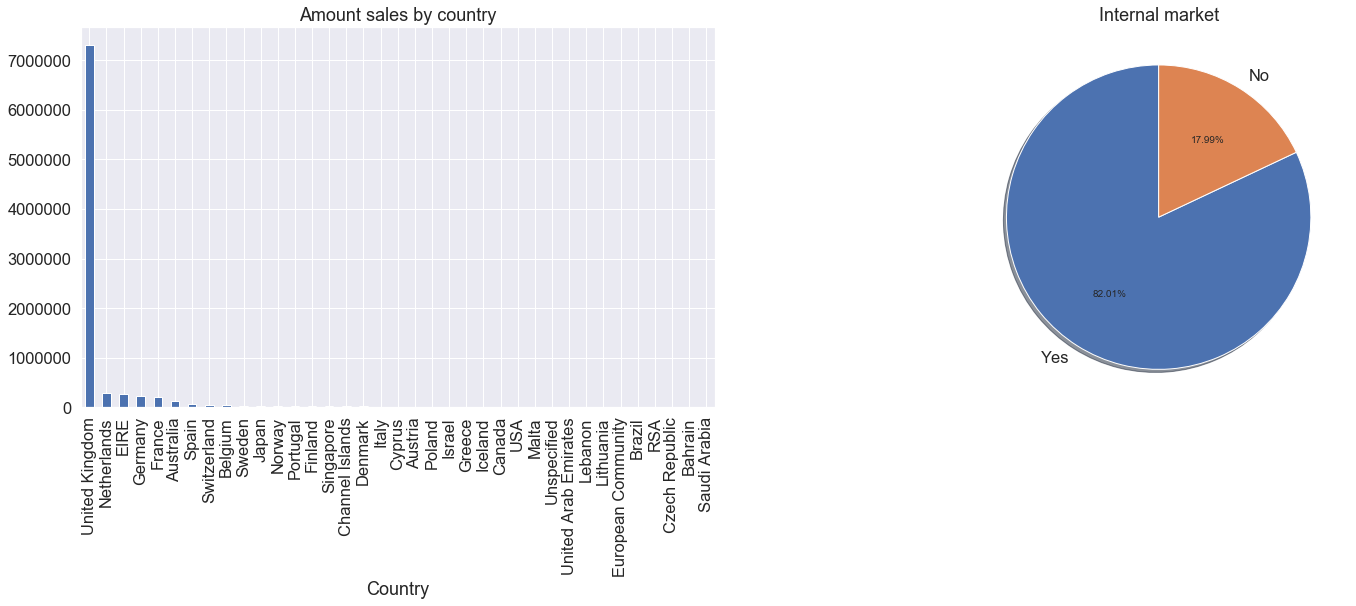

In [20]:
#画出每个国家的销售额
fig = plt.figure(figsize=(25,7))
f1 = fig.add_subplot(121)
g = df_eda.groupby(['Country']).total.sum().sort_values(ascending=False).plot(kind='bar',title='Amount sales by country')
df_eda['Internal'] = df_eda.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No')
f2 = fig.add_subplot(122)
market = df_eda.groupby(['Internal']).total.sum().sort_values(ascending=False)
g = plt.pie(market,labels=market.index,autopct='%1.2f%%',shadow=True,startangle=90)     #autopct设置百分比的格式
plt.title('Internal market')
plt.show()

#### 成交信息

In [21]:
print(f"最早订单：{df_eda['InvoiceDate'].min()}")
print(f"最晚订单：{df_eda['InvoiceDate'].max()}")

最早订单：2010-12-01 08:26:00
最晚订单：2011-12-09 12:50:00


No handles with labels found to put in legend.
E:\Anaconda3\anaconda\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



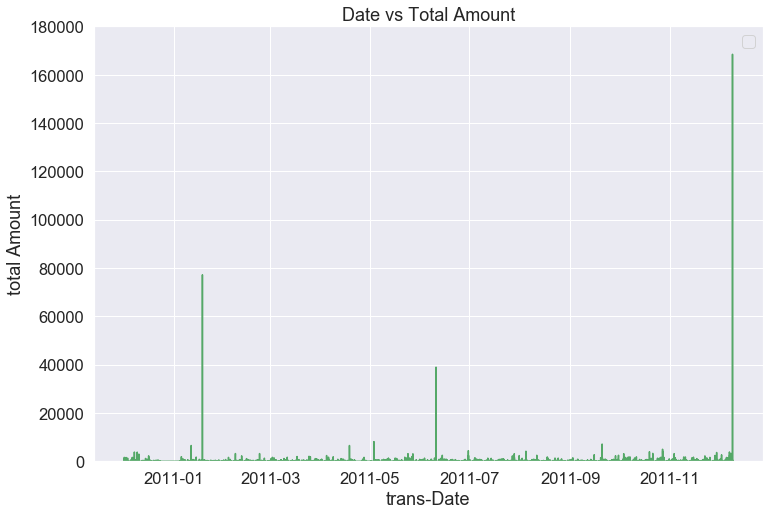

In [22]:
plt.figure(figsize=(12,8))
plt.plot(df_eda['InvoiceDate'],df_eda['total'],color='g')
plt.xlabel('trans-Date')
plt.ylabel('total Amount')
plt.title('Date vs Total Amount')
plt.ylim(0,180000)
plt.legend()
plt.show()

In [23]:
df_eda['Weekday'] = df_eda['InvoiceDate'].dt.weekday
df_eda['Weekday_name'] = df_eda['InvoiceDate'].dt.weekday_name

E:\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

`Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.



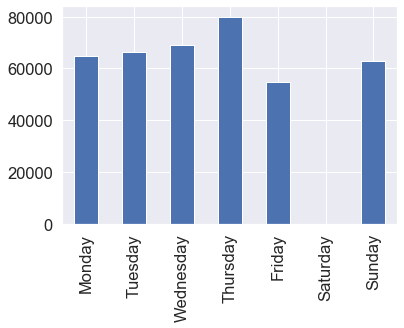

In [24]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

df_eda['DAY_OF_WEEK'] = pd.Categorical(df_eda['Weekday_name'],categories=days,ordered=True)
crashes_by_day = df_eda['DAY_OF_WEEK'].value_counts()
crashes_by_day = crashes_by_day.sort_index()
crashes_by_day.plot('bar')

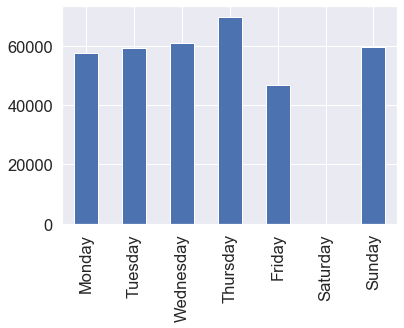

In [25]:
df_uk = df_eda.loc[df_eda['Country']=='United Kingdom']
#df_uk['DAY_OF_WEEK'] = pd.Categorical(df_uk['Weekday_name'],categories=days,ordered=True)
crashes_by_day_uk = df_uk['DAY_OF_WEEK'].value_counts()
crashes_by_day_uk = crashes_by_day_uk.sort_index()
crashes_by_day_uk.plot(kind='bar')

#### 重要客户

E:\Anaconda3\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 65306 missing from current font.

E:\Anaconda3\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning:

Glyph 65306 missing from current font.



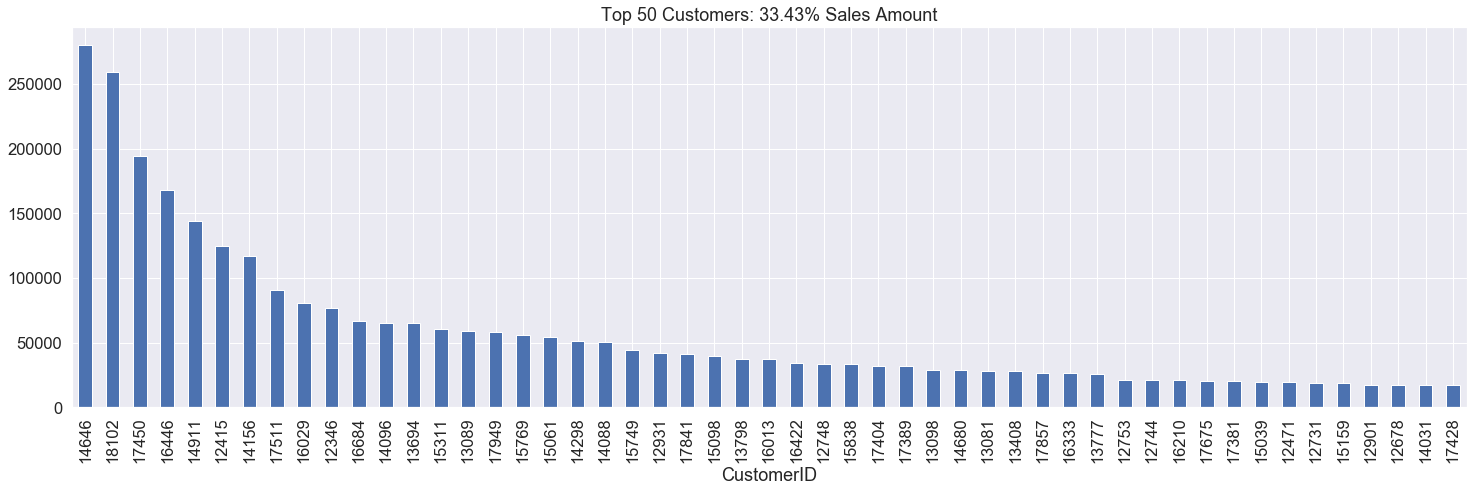

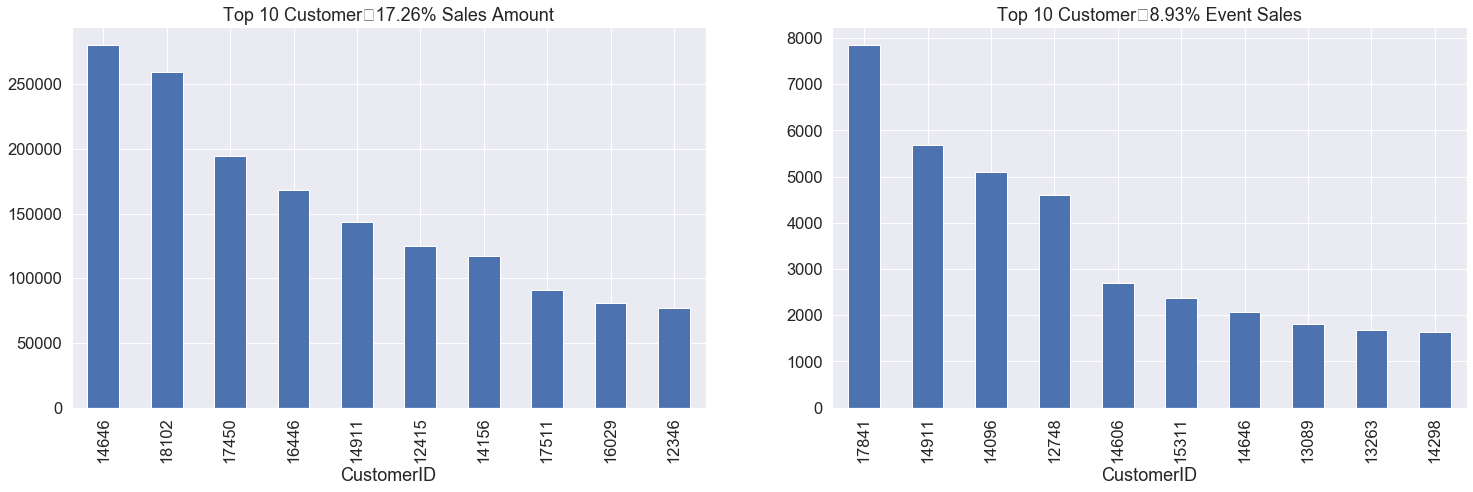

In [26]:
fig = plt.figure(figsize=(25,7))
PercentSales_top50 = np.round(\
    (df_eda.groupby(['CustomerID']).total.sum().sort_values(ascending=False)[:51].sum()\
     /df_eda.groupby(['CustomerID']).total.sum().sort_values().sum())\
     *100,2)
g = df_eda.groupby(['CustomerID']).total.sum().sort_values(ascending=False)[:51]\
    .plot(kind='bar',title='Top 50 Customers: {:3.2f}% Sales Amount'.format(PercentSales_top50))

fig = plt.figure(figsize=(25,7))
f1 = fig.add_subplot(121)
PercentSales_top10 = np.round(
    (df_eda.groupby(['CustomerID']).total.sum().sort_values(ascending=False)[:10].sum()/\
     df_eda.groupby(['CustomerID']).total.sum().sort_values().sum())
    *100,2)
h_total = df_eda.groupby(['CustomerID']).total.sum().sort_values(ascending=False)[:10]\
    .plot(kind='bar',title='Top 10 Customer：{:3.2f}% Sales Amount'.format(PercentSales_top10))

f2 = fig.add_subplot(122)
PercentSales_top10_times = round(df_eda.groupby(['CustomerID']).total.count().sort_values(ascending=False)[:10].sum()\
    /df_eda.groupby(['CustomerID']).total.count().sort_values(ascending=False).sum()\
    *100,2)
h_count = df_eda.groupby(['CustomerID']).total.count().sort_values(ascending=False)[:10]\
    .plot(kind='bar',title='Top 10 Customer：{:3.2f}% Event Sales'.format(PercentSales_top10_times))

#### Products

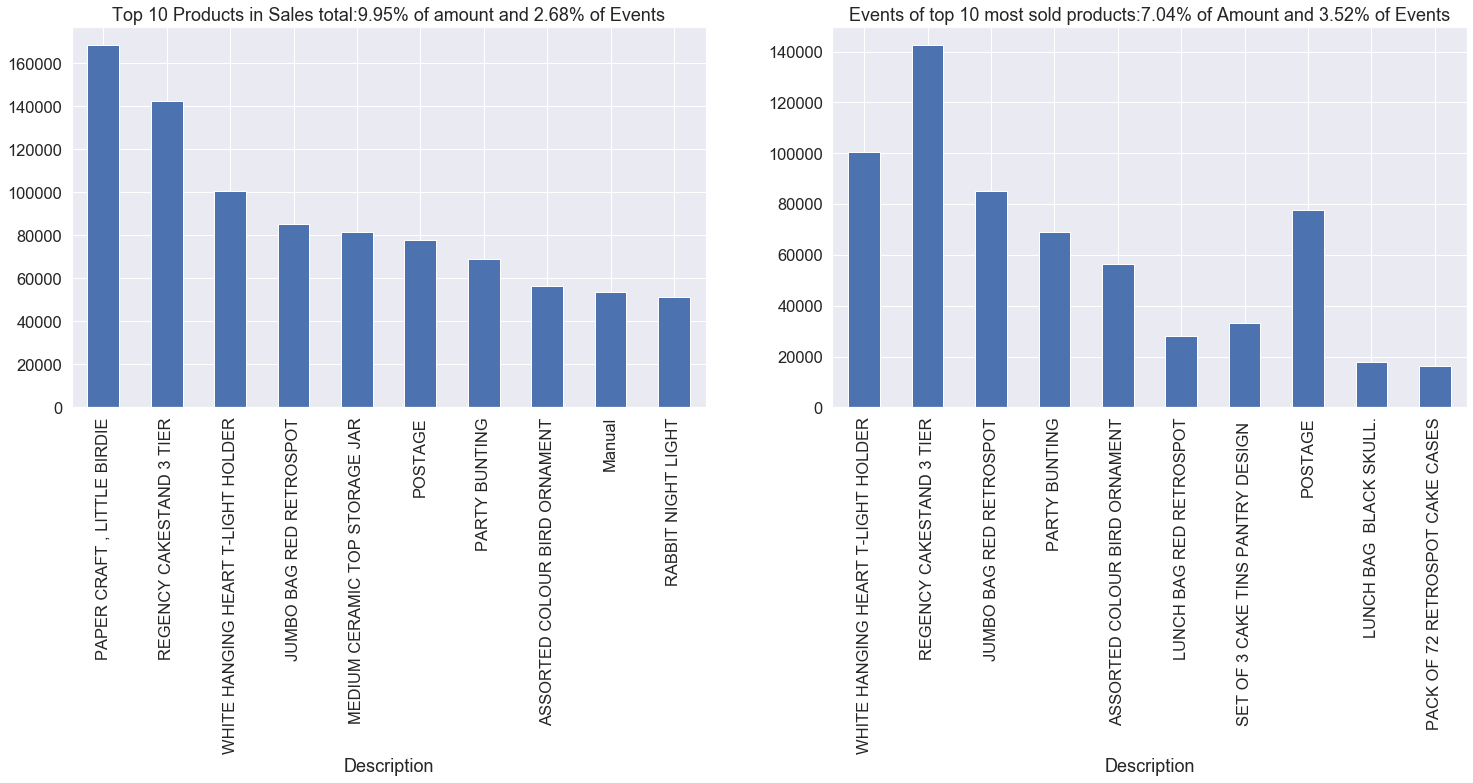

In [27]:
AmountSum = df_eda.groupby('Description').total.sum().sort_values(ascending=False)
inv = df_eda[['Description','InvoiceNo']].groupby(['Description']).InvoiceNo.unique().agg(np.size).sort_values(ascending=False)

fig = plt.figure(figsize=(25,7))
f1 = fig.add_subplot(121)
Top10 = list(AmountSum[:10].index)
PercentSales = np.round(AmountSum[Top10].sum()/AmountSum.sum()*100,2)
PercentEvents = np.round(inv[Top10].sum()/inv.sum()*100,2)     #以订单数为基础，不能使用AmountSum
g = AmountSum[Top10].plot(kind='bar',title='Top 10 Products in Sales total:{:3.2f}% of amount and {:3.2f}% of Events'\
    .format(PercentSales,PercentEvents))     #产生金额最多的产品占比（销售金额比例和交易次数比例）

f1 = fig.add_subplot(122)
Top10_Ev = list(inv[:10].index)
PercentSales_deal = np.round(AmountSum[Top10_Ev].sum()/AmountSum.sum()*100,2)
PercentEvents_deal = np.round(inv[Top10_Ev].sum()/inv.sum()*100,2)
h = AmountSum[Top10_Ev].plot(kind='bar',title='Events of top 10 most sold products:{:3.2f}% of Amount and {:3.2f}% of Events'\
    .format(PercentSales_deal,PercentEvents_deal))     #交易次数最多的产品占比（销售金额比例和交易次数比例）

## RMF Customer Segmentation 顾客分类

### 使用零售数据进行RFM模型分析从而提高顾客终身价值

In [28]:
df1 = df_eda

In [29]:
df1.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice CustomerID         Country  total Internal  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  15.30      Yes   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  20.34      Yes   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  22.00      Yes   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  20.34      Yes   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom  20.34      Yes   
5 2010-12-01 08:26:00       7.65      17850  United Kingdom  15.30      Yes   
6 2010-12-01 08:26:00       4.25      17850  United Kingdom  25.50      Yes   
7 2010-12-01 08:28:00       1.85      17850  United Kingdom  11.10      Yes   
8 2010-12-01 08:28:00       1.85      17850  United Kingdom  11.10      Yes   
9 2010-12-01 08:34:00       1.69      13047  United Kingdom  54.08      Yes   

   Weekday Weekday_name DAY_OF_WEEK  
0        2    Wednesday   Wednesday  
1        2    Wednesday   Wednesday  
2        2    Wednesday   Wednesday  
3        2    Wednesday   Wednesday  
4        2    Wednesday   Wednesday  
5        2    Wednesday   Wednesday  
6        2    Wednesday   Wednesday  
7        2    Wednesday   Wednesday  
8        2    Wednesday   Wednesday  
9        2    Wednesday   Wednesday

In [30]:
df1.shape     #扩展的列在使用mechine learning时很重要

(397884, 13)

#### Recency

In [31]:
refrence_date = df1.InvoiceDate.max()+datetime.timedelta(days=1)
refrence_date     #确定参考截止时间

Timestamp('2011-12-10 12:50:00')

In [32]:
print(f"refrence Date：{refrence_date}")
df1['days_since_last_purchase'] = (refrence_date-df1.InvoiceDate).astype('timedelta64[D]')
customer_history_df = df1[['CustomerID','days_since_last_purchase']].groupby('CustomerID').min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'},inplace=True)
customer_history_df.describe().transpose()

refrence Date：2011-12-10 12:50:00


count       mean         std  min   25%   50%    75%    max
recency  4338.0  92.536422  100.014169  1.0  18.0  51.0  142.0  374.0

In [33]:
customer_history_df.head()

CustomerID  recency
0      12346    326.0
1      12347      2.0
2      12348     75.0
3      12349     19.0
4      12350    310.0

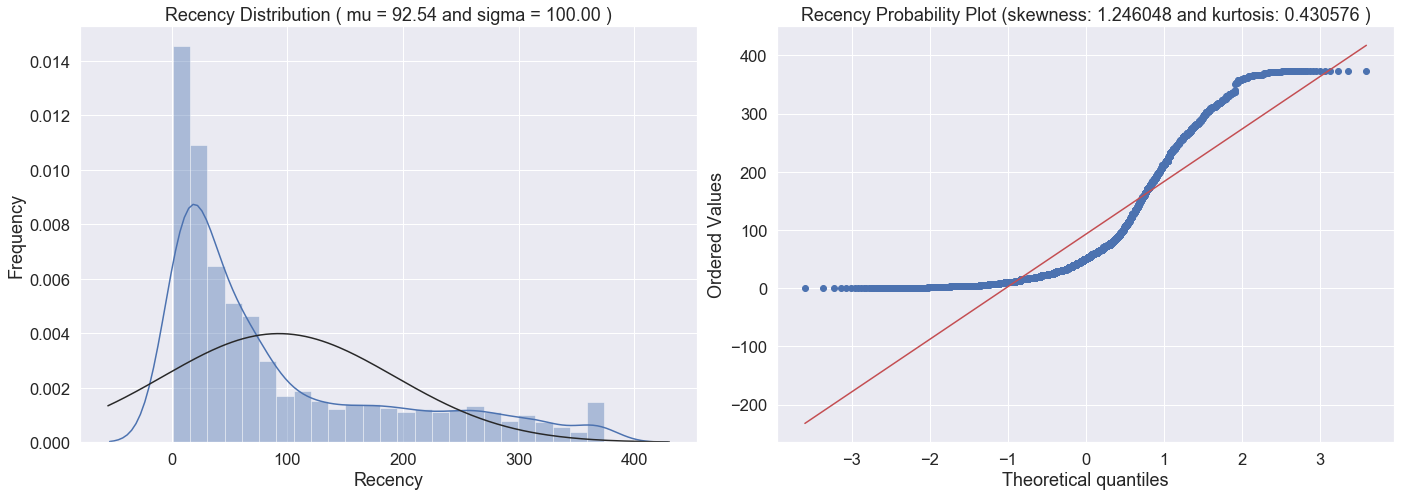

In [34]:
def QQ_plot(data,measure):
    fig = plt.figure(figsize=(20,7))
    
    #get the fitted parameters used by the function
    (mu,sigma) = norm.fit(data)     #正态化
    
    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data,fit=norm)
    fig1.set_title(measure+' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu,sigma),loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data,plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(),data.kurt()),loc='center')
    
    plt.tight_layout()     #适应布局，避免标签被遮挡
    plt.show()

QQ_plot(customer_history_df.recency,'Recency')

#### Frequency构面频次分布

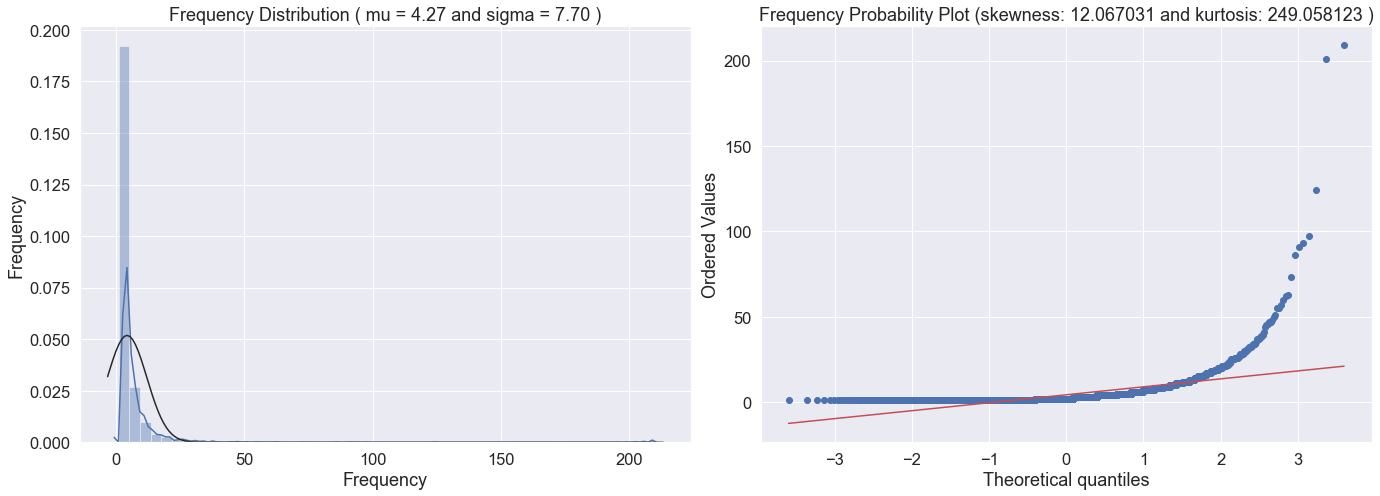

In [35]:
customer_freq = (df1[['CustomerID','InvoiceNo']].groupby(['CustomerID','InvoiceNo'])).count().reset_index().\
    groupby(['CustomerID']).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency,'Frequency')

In [36]:
customer_freq.describe().transpose()

count      mean       std  min  25%  50%  75%    max
frequency  4338.0  4.272015  7.697998  1.0  1.0  2.0  5.0  209.0

#### Moneatry

In [37]:
customer_history_df

CustomerID  recency  frequency
0         12346    326.0          1
1         12347      2.0          7
2         12348     75.0          4
3         12349     19.0          1
4         12350    310.0          1
...         ...      ...        ...
4333      18280    278.0          1
4334      18281    181.0          1
4335      18282      8.0          2
4336      18283      4.0         16
4337      18287     43.0          3

[4338 rows x 3 columns]

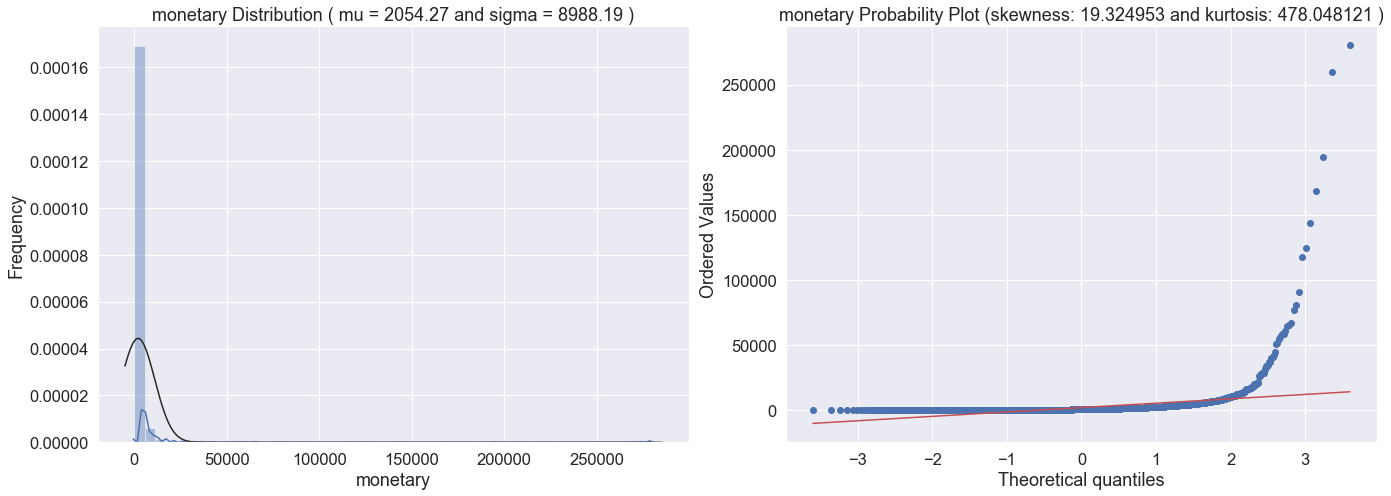

In [38]:
customer_monetary_val = df1[['CustomerID','total']].groupby('CustomerID').sum().reset_index()
customer_history_df_monetary = customer_history_df.merge(customer_monetary_val)
customer_history_df_monetary.rename(columns={'total':'monetary'},inplace=True)
QQ_plot(customer_history_df_monetary.monetary,'monetary')     #只需要monetary这一列，不是传整个dataFrame

In [39]:
customer_history_df_monetary.describe().transpose()

count         mean          std   min      25%      50%      75%  \
recency    4338.0    92.536422   100.014169  1.00   18.000   51.000   142.00   
frequency  4338.0     4.272015     7.697998  1.00    1.000    2.000     5.00   
monetary   4338.0  2054.266460  8989.230441  3.75  307.415  674.485  1661.74   

                 max  
recency       374.00  
frequency     209.00  
monetary   280206.02

In [40]:
rfmtable = customer_history_df_monetary
rfmtable.head()

CustomerID  recency  frequency  monetary
0      12346    326.0          1  77183.60
1      12347      2.0          7   4310.00
2      12348     75.0          4   1797.24
3      12349     19.0          1   1757.55
4      12350    310.0          1    334.40

In [41]:
#查看monetary排第一的客户的详细信息
df1[df1.CustomerID=='12346']

InvoiceNo StockCode                     Description  Quantity  \
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   

              InvoiceDate  UnitPrice CustomerID         Country    total  \
61619 2011-01-18 10:01:00       1.04      12346  United Kingdom  77183.6   

      Internal  Weekday Weekday_name DAY_OF_WEEK  days_since_last_purchase  
61619      Yes        1      Tuesday     Tuesday                     326.0

<span style="color:navy;font-size:15px;font-weight:bold">此用户仅购买一次，数量巨大，很久没再光顾</span>

### RFM打分

In [42]:
quantiles = rfmtable.quantile(q=[0.25,0.5,0.75])     #手动将指标四分位划分
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary': {0.25: 307.41499999999996,
  0.5: 674.4849999999999,
  0.75: 1661.7400000000007}}

In [43]:
#想要粘度高，忠诚度高和收入高的用户（一般打分分为3~5段，此处分4段）
def RScore(x,standar,data):
    if x <= data[standar][0.25]:
        return 1
    elif x < data[standar][0.5]:
        return 2
    elif x < data[standar][0.75]:
        return 3
    else:
        return 4
    
def FMScore(x,standar,data):
    if x <= data[standar][0.25]:
        return 4
    elif x < data[standar][0.5]:
        return 3
    elif x < data[standar][0.75]:
        return 2
    else:
        return 1

In [44]:
segmented_rfm = rfmtable

In [45]:
segmented_rfm['r_quantiles'] = segmented_rfm['recency'].apply(RScore,args=('recency',quantiles,))
segmented_rfm['f_quantiles'] = segmented_rfm['frequency'].apply(FMScore,args=('frequency',quantiles,))
segmented_rfm['m_quantiles'] = segmented_rfm['monetary'].apply(FMScore,args=('monetary',quantiles,))
segmented_rfm

CustomerID  recency  frequency  monetary  r_quantiles  f_quantiles  \
0         12346    326.0          1  77183.60            4            4   
1         12347      2.0          7   4310.00            1            1   
2         12348     75.0          4   1797.24            3            2   
3         12349     19.0          1   1757.55            2            4   
4         12350    310.0          1    334.40            4            4   
...         ...      ...        ...       ...          ...          ...   
4333      18280    278.0          1    180.60            4            4   
4334      18281    181.0          1     80.82            4            4   
4335      18282      8.0          2    178.05            1            2   
4336      18283      4.0         16   2094.88            1            1   
4337      18287     43.0          3   1837.28            2            2   

      m_quantiles  
0               1  
1               1  
2               1  
3               1  
4               3  
...           ...  
4333            4  
4334            4  
4335            4  
4336            1  
4337            1  

[4338 rows x 7 columns]

In [46]:
#RFM score = r*100 + f*10 + m     此标准下，111是最好的客户
segmented_rfm['RFMscore'] = segmented_rfm.r_quantiles.map(str)\
                                + segmented_rfm.f_quantiles.map(str)\
                                + segmented_rfm.m_quantiles.map(str)

In [47]:
segmented_rfm

CustomerID  recency  frequency  monetary  r_quantiles  f_quantiles  \
0         12346    326.0          1  77183.60            4            4   
1         12347      2.0          7   4310.00            1            1   
2         12348     75.0          4   1797.24            3            2   
3         12349     19.0          1   1757.55            2            4   
4         12350    310.0          1    334.40            4            4   
...         ...      ...        ...       ...          ...          ...   
4333      18280    278.0          1    180.60            4            4   
4334      18281    181.0          1     80.82            4            4   
4335      18282      8.0          2    178.05            1            2   
4336      18283      4.0         16   2094.88            1            1   
4337      18287     43.0          3   1837.28            2            2   

      m_quantiles RFMscore  
0               1      441  
1               1      111  
2               1      321  
3               1      241  
4               3      443  
...           ...      ...  
4333            4      444  
4334            4      444  
4335            4      124  
4336            1      111  
4337            1      221  

[4338 rows x 8 columns]

In [48]:
segmented_rfm[segmented_rfm['RFMscore']=='111'].sort_values('monetary',ascending=False).head(10) #查出得分排名前十的顾客(同分则比较Monetary)

CustomerID  recency  frequency   monetary  r_quantiles  f_quantiles  \
1689      14646      2.0         73  280206.02            1            1   
4201      18102      1.0         60  259657.30            1            1   
3728      17450      8.0         46  194550.79            1            1   
1879      14911      1.0        201  143825.06            1            1   
1333      14156     10.0         55  117379.63            1            1   
3771      17511      3.0         31   91062.38            1            1   
3176      16684      4.0         28   66653.56            1            1   
1289      14096      4.0         17   65164.79            1            1   
996       13694      4.0         50   65039.62            1            1   
2176      15311      1.0         91   60767.90            1            1   

      m_quantiles RFMscore  
1689            1      111  
4201            1      111  
3728            1      111  
1879            1      111  
1333            1      111  
3771            1      111  
3176            1      111  
1289            1      111  
996             1      111  
2176            1      111

In [49]:
print(segmented_rfm['RFMscore'].value_counts().count())
print(segmented_rfm['RFMscore'].max())
print(segmented_rfm['RFMscore'].min())

46
444
111


### 对不同得分的用户将采用不同的策略
<p style="color:red;">
R分段	  &nbsp;&nbsp; 得分	F分段	 &nbsp;&nbsp;       得分	 &nbsp;   M分段	&nbsp;&nbsp;得分<br>
活跃用户	1	&nbsp;&nbsp;忠实客户&nbsp;&nbsp;	      1	         高贡献&nbsp;&nbsp;&nbsp;&nbsp;1<br>
沉默用户	2	&nbsp;&nbsp;成熟客户&nbsp;&nbsp;	      2	         中高贡献&nbsp;&nbsp;&nbsp;&nbsp;2<br>
睡眠用户	3	&nbsp;&nbsp;老客户	 &nbsp;&nbsp;&nbsp;&nbsp;3	    &nbsp;中贡献&nbsp;&nbsp;&nbsp;&nbsp;3<br>
流失用户	4	&nbsp;&nbsp;新客户	 &nbsp;&nbsp;&nbsp;&nbsp;4	    &nbsp;低贡献&nbsp;&nbsp;&nbsp;&nbsp;4<br>
基于此做打分分组，制定不同的策略，比如

0 - 122, 最有价值客户，价格不会是很敏感，所以主要推广忠实项目和新品<br>
122 - 223，快要逐渐失去的客户，email或者渠道推广一下<br>
223 - 333, 最近没怎么购买的有价值客户，需要进一步激活，给一下打折，做一波email推广<br>
或者可以分得更细致，主要看运营能力</p>

In [50]:
segmented_rfm['RFMscore'] = segmented_rfm['RFMscore'].astype(int)
def rfm_level(score):
    if (score > 0 and score < 122):
        return 1
    elif (score >= 122 and score < 223):
        return 2
    elif (score >= 223 and score < 333):
        return 3
    else:
        return 4
segmented_rfm['RFMscore_level'] = segmented_rfm['RFMscore'].apply(rfm_level).astype(str)

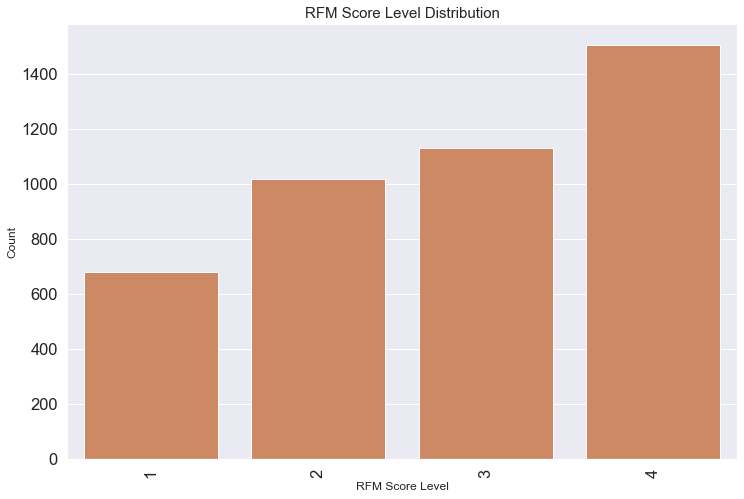

In [51]:
### 不同的rfm分布
#color = sns.color_palette()
#plt.figure(figsize=(12,8))
#sns.countplot(x='RFMscore_level',data=segmented_rfm,color=color[1])
#plt.xlabel('RFM Score level')
#plt.ylabel('Count')
#plt.xticks(rotation='vertical')
#plt.title('RFM score Level Distribution',fontsize=15)
#plt.show()

color = sns.color_palette()

plt.figure(figsize=(12,8))
sns.countplot(x='RFMscore_level',data=segmented_rfm, color = color[1])
plt.ylabel('Count',fontsize=12)
plt.xlabel('RFM Score Level', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('RFM Score Level Distribution',fontsize=15)
plt.show()

In [52]:
segmented_rfm

CustomerID  recency  frequency  monetary  r_quantiles  f_quantiles  \
0         12346    326.0          1  77183.60            4            4   
1         12347      2.0          7   4310.00            1            1   
2         12348     75.0          4   1797.24            3            2   
3         12349     19.0          1   1757.55            2            4   
4         12350    310.0          1    334.40            4            4   
...         ...      ...        ...       ...          ...          ...   
4333      18280    278.0          1    180.60            4            4   
4334      18281    181.0          1     80.82            4            4   
4335      18282      8.0          2    178.05            1            2   
4336      18283      4.0         16   2094.88            1            1   
4337      18287     43.0          3   1837.28            2            2   

      m_quantiles  RFMscore RFMscore_level  
0               1       441              4  
1               1       111              1  
2               1       321              3  
3               1       241              3  
4               3       443              4  
...           ...       ...            ...  
4333            4       444              4  
4334            4       444              4  
4335            4       124              2  
4336            1       111              1  
4337            1       221              2  

[4338 rows x 9 columns]

## 基于统计模型分类RFM指标

### K-means Clustering

In [53]:
customer_history_df = segmented_rfm     #迷惑行为

In [54]:
customer_history_df.head(1)

CustomerID  recency  frequency  monetary  r_quantiles  f_quantiles  \
0      12346    326.0          1   77183.6            4            4   

   m_quantiles  RFMscore RFMscore_level  
0            1       441              4

In [55]:
customer_history_df.describe()

recency    frequency       monetary  r_quantiles  f_quantiles  \
count  4338.000000  4338.000000    4338.000000  4338.000000  4338.000000   
mean     92.536422     4.272015    2054.266460     2.494006     2.431535   
std     100.014169     7.697998    8989.230441     1.127184     1.203155   
min       1.000000     1.000000       3.750000     1.000000     1.000000   
25%      18.000000     1.000000     307.415000     1.000000     1.000000   
50%      51.000000     2.000000     674.485000     3.000000     2.000000   
75%     142.000000     5.000000    1661.740000     4.000000     4.000000   
max     374.000000   209.000000  280206.020000     4.000000     4.000000   

       m_quantiles     RFMscore  
count  4338.000000  4338.000000  
mean      2.500000   276.215998  
std       1.118369   119.841070  
min       1.000000   111.000000  
25%       1.250000   144.000000  
50%       2.500000   311.000000  
75%       3.750000   411.000000  
max       4.000000   444.000000

In [60]:
?preprocessing.StandardScaler     #标准正态化

In [56]:
customer_history_df['recency_log'] = customer_history_df.recency.apply(math.log)
customer_history_df['frequency_log'] = customer_history_df.frequency.apply(math.log)
customer_history_df['monetary_log'] = customer_history_df.monetary.apply(math.log)
feature_vector = ['recency_log','frequency_log','monetary_log']
X_subset = customer_history_df[feature_vector]
scaler = preprocessing.StandardScaler().fit(X_subset)     #扩展列后正态化
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled,columns=X_subset.columns).describe().T

count          mean       std       min       25%       50%  \
recency_log    4338.0 -1.027980e-16  1.000115 -2.630445 -0.612424  0.114707   
frequency_log  4338.0 -2.355833e-16  1.000115 -1.048610 -1.048610 -0.279044   
monetary_log   4338.0 -1.202102e-16  1.000115 -4.179280 -0.684183 -0.060942   

                    75%       max  
recency_log    0.829652  1.505796  
frequency_log  0.738267  4.882714  
monetary_log   0.654244  4.721395

In [57]:
from mpl_toolkits.mplot3d import Axes3D

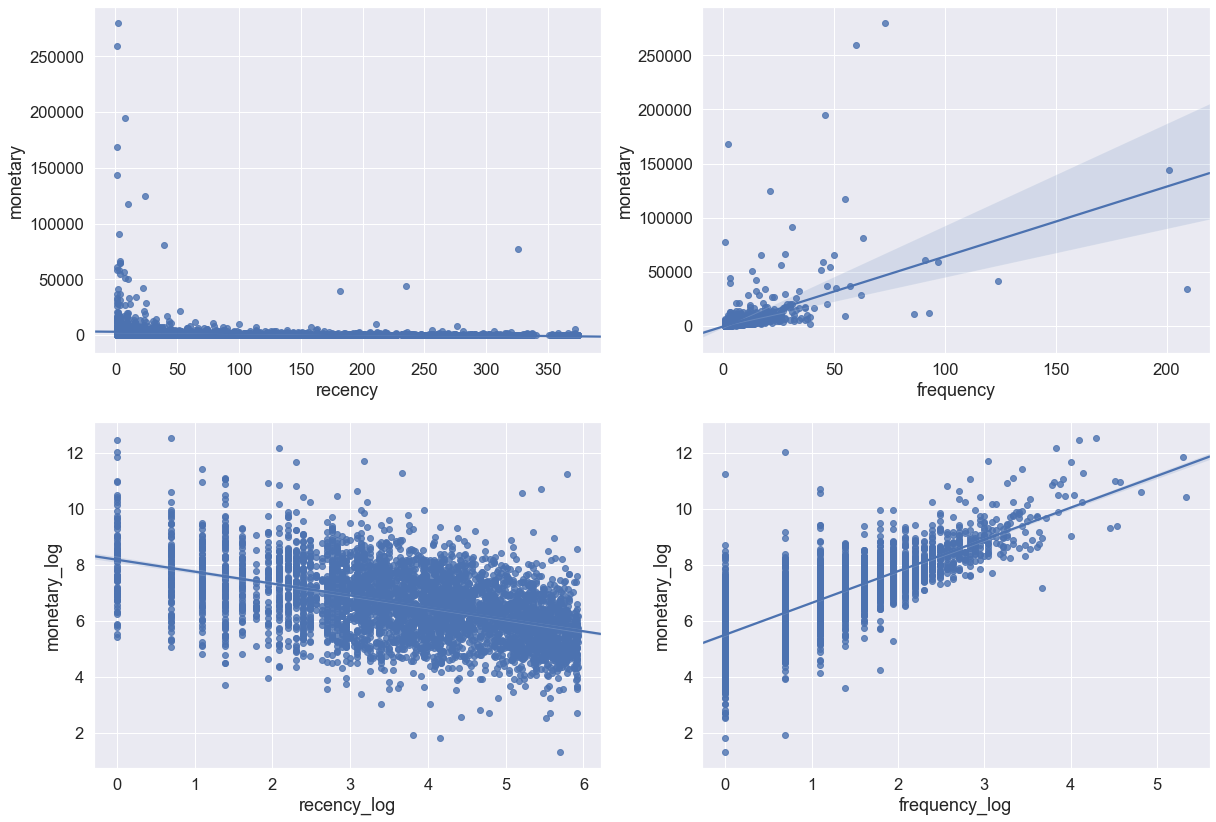

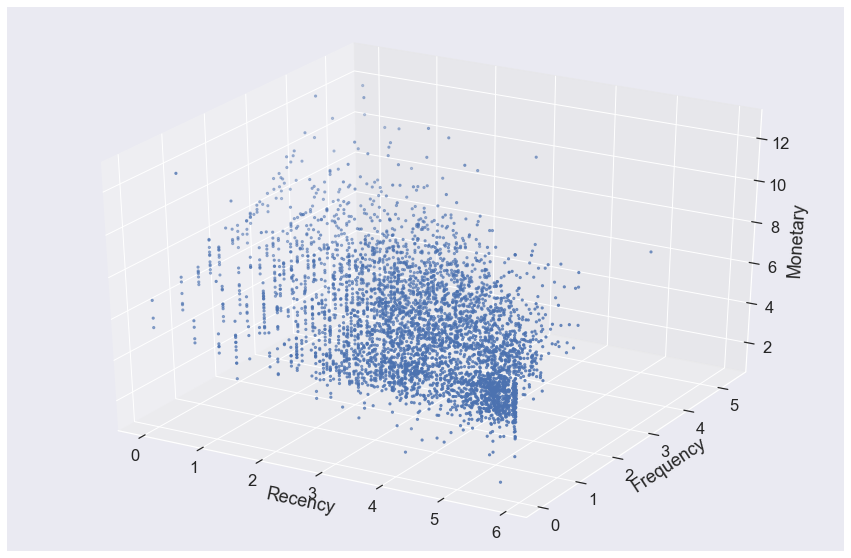

In [59]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221)
sns.regplot(x='recency',y='monetary',data=customer_history_df)
f1 = fig.add_subplot(222)
sns.regplot(x='frequency',y='monetary',data=customer_history_df)
f1 = fig.add_subplot(223)
sns.regplot(x='recency_log',y='monetary_log',data=customer_history_df)
f1 = fig.add_subplot(224)
sns.regplot(x='frequency_log',y='monetary_log',data=customer_history_df)

fig1 = plt.figure(figsize=(15,10))
ax = fig1.add_subplot(111,projection='3d')

xs = customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.monetary_log
ax.scatter(xs,ys,zs,s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

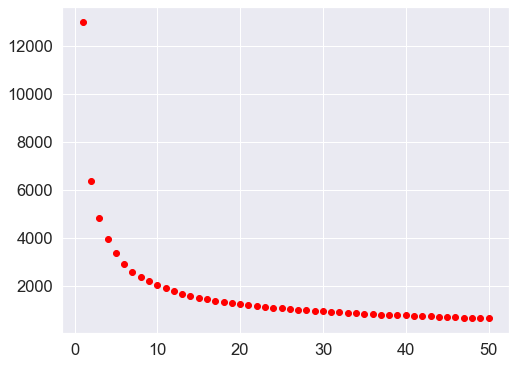

In [68]:
c1 = 50
corte = 0.1     #下降率(10%)

anterior = 100000000000000     #给样本点与其它cluster的距离之和留足够的富余
cost = []
K_best = c1

for k in range(1,c1+1):
    model = KMeans(n_clusters=k,
                   init = 'k-means++',     #默认为random
                   n_init = 10,
                   max_iter = 300,
                   tol = 1e-04,
                   random_state = 101
                  )
    model = model.fit(X_scaled)
#     labels = model.labels_
#     interia = model.interia_
# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if(K_best == c1) and ((anterior-interia)/anterior < corte):K_best = k - 1
    cost.append(interia)
    anterior = interia
    
plt.figure(figsize=(8,6))
plt.scatter(range(1,c1+1),cost,c='red')
plt.show()

In [69]:
K_best

7

the best k sugeest:7


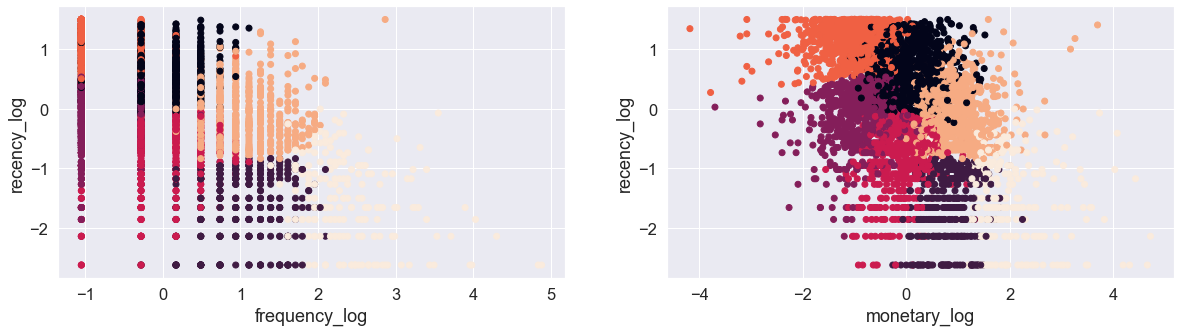

In [77]:
#create Kmeans model with best K
print(f'the best k sugeest:{K_best}')
model = KMeans(n_clusters=K_best,init='k-means++',n_init=10,max_iter=300,tol=1e-04,random_state=101)
model = model.fit(X_scaled)
labels = model.labels_

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x=X_scaled[:,1],y=X_scaled[:,0],c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])

ax = fig.add_subplot(122)
plt.scatter(x=X_scaled[:,2],y=X_scaled[:,0],c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])
plt.show()

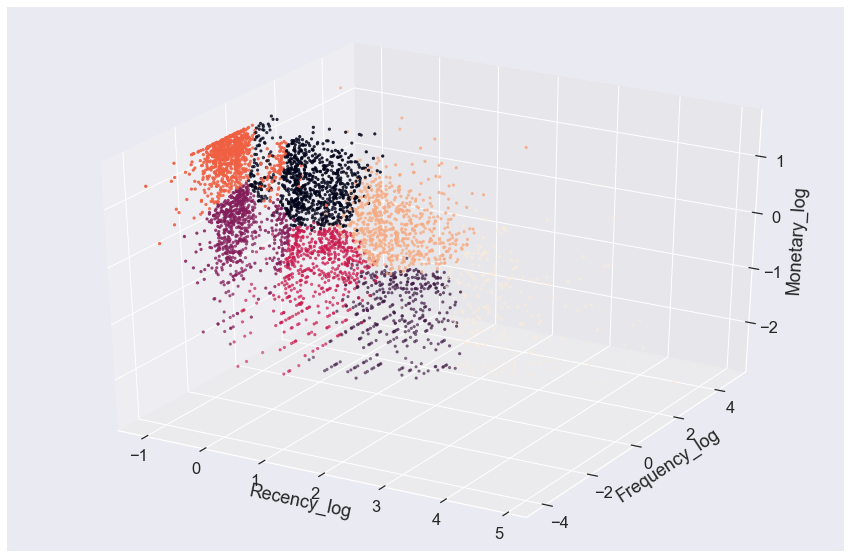

In [80]:
#3D plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111,projection='3d')

xs = X_scaled[:,1]
ys = X_scaled[:,2]
zs = X_scaled[:,0]

ax.scatter(xs,ys,zs,s=5,c=model.labels_.astype(float))
ax.set_xlabel('Recency_log')
ax.set_ylabel('Frequency_log')
ax.set_zlabel('Monetary_log')

plt.show()

### Silhouette analysis on K-Means clustering

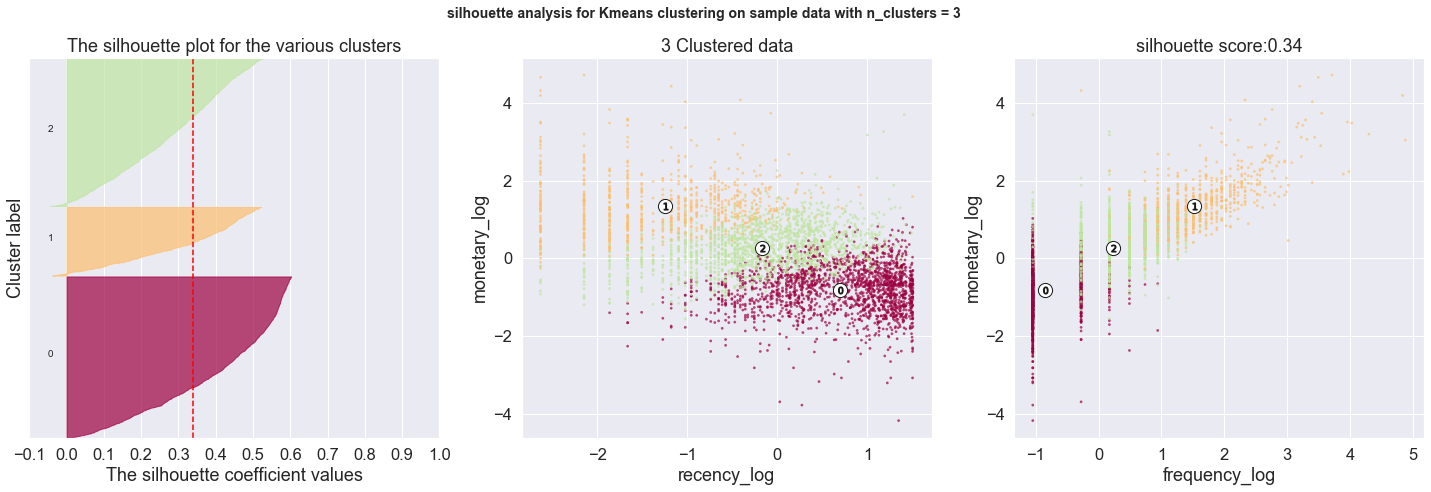

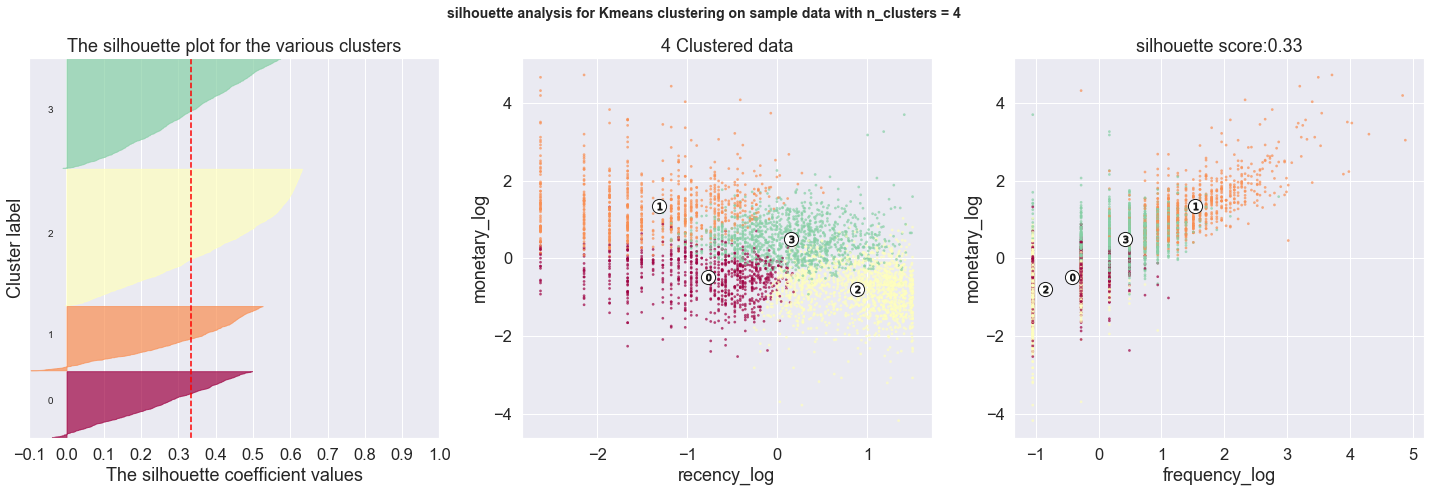

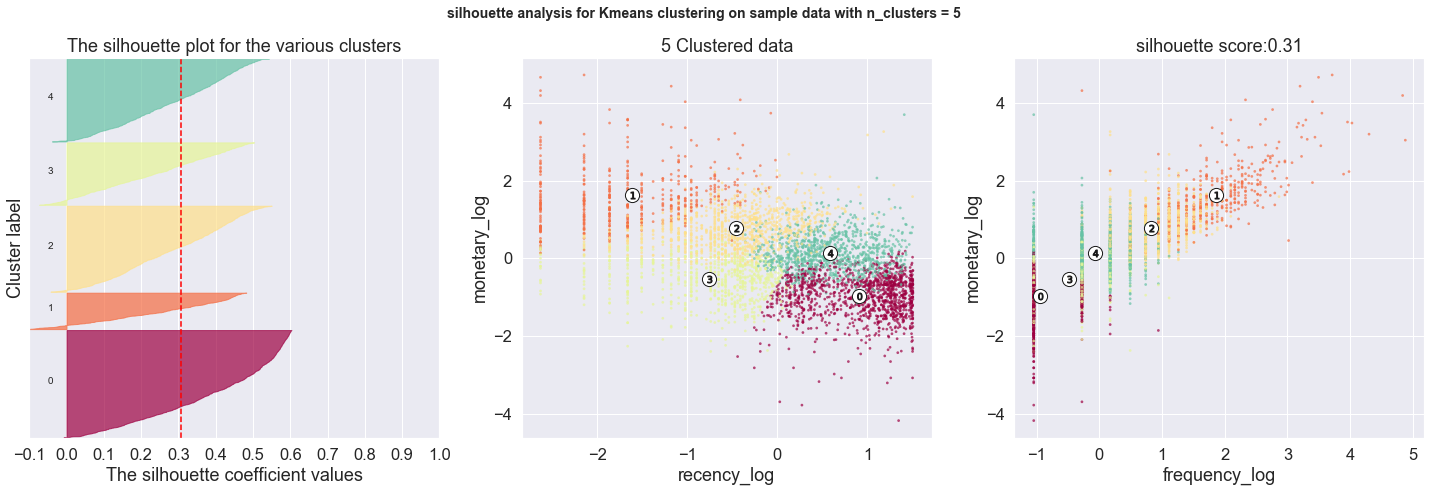

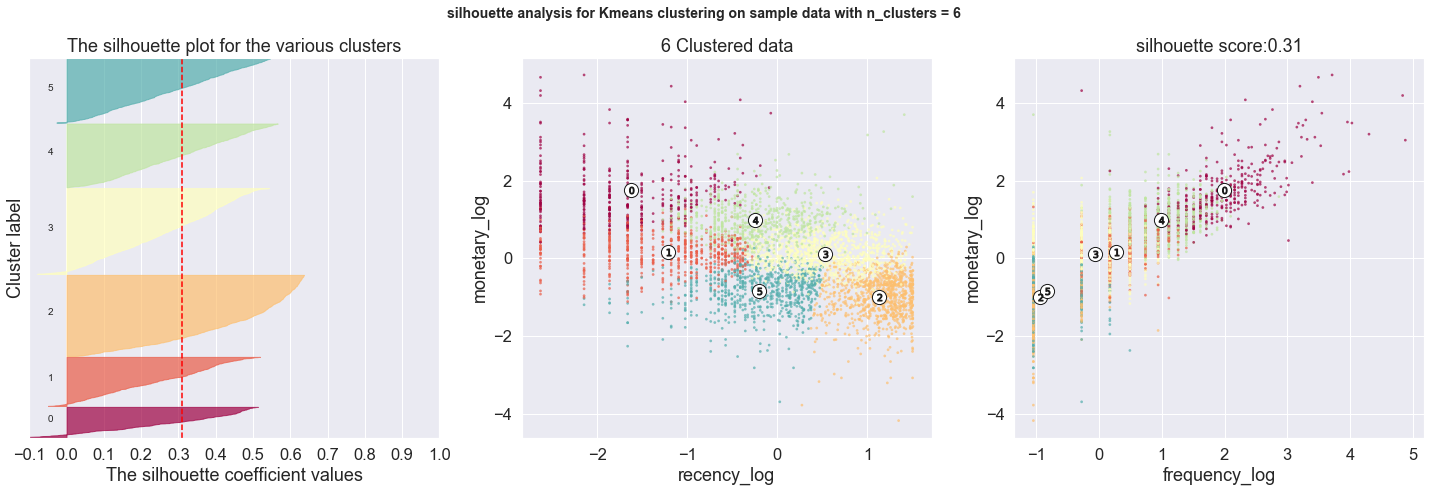

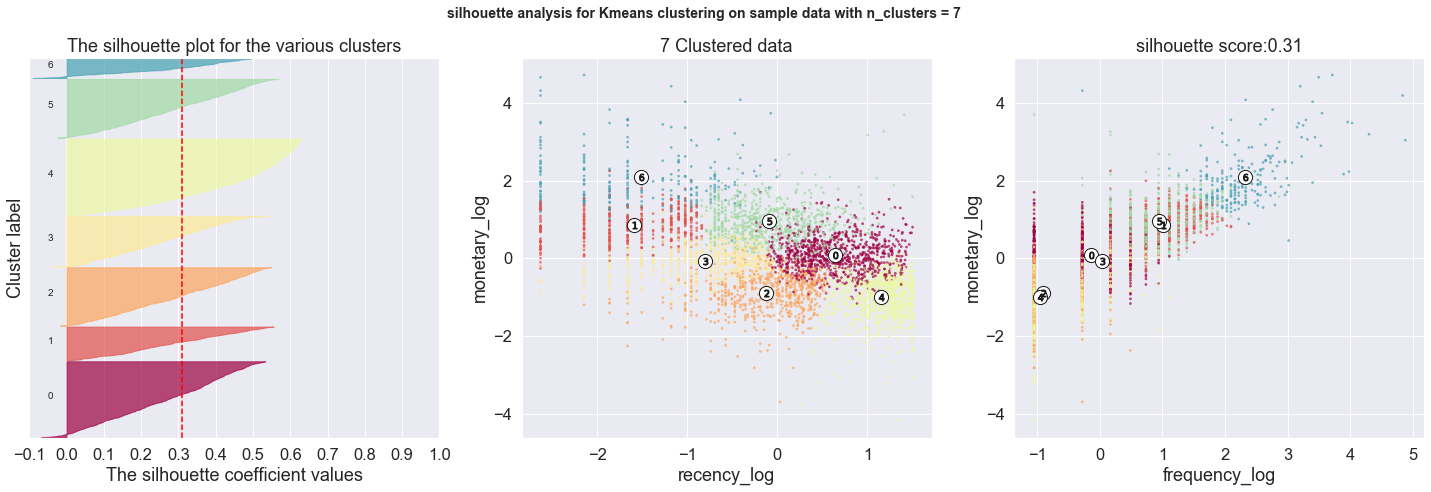

In [96]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    fig.set_size_inches(25,7)
    ax1.set_xlim([-0.1,1])
    ax1.set_ylim([0,len(X_scaled)+(n_clusters+1)*10])
    cluster = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,tol=1e-04,random_state=101)
    cluster_labels = cluster.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X=X_scaled,labels=cluster_labels)     #放入训练集合预测结果列表，得到各样本的轮廓评分
    cluster_centers.update({n_clusters:{'cluster_center':cluster.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}})
    
    sample_silhouette_values = silhouette_samples(X=X_scaled,labels=cluster_labels)     #合成各簇评分的样本
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()     #按照label将各簇每一个样本的轮廓得分降序排序
                            
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.Spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        ax1.text(-0.05,y_lower+0.5*size_cluster_i,str(i))
        y_lower = y_upper + 10     #10 for samples
    
    ax1.set_title('The silhouette plot for the various clusters')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
                            
    centers = cluster.cluster_centers_
    x = 0
    y = 2
#     ax2.scatter(X_scaled[:,x],X_scaled[:,y],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k')
#     ax2.scatter(centers[:,x],centers[:,y],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    ax2.scatter(X_scaled[:,x],X_scaled[:,y],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k')   
    ax2.scatter(centers[:,x],centers[:,y],marker='o',c="white",alpha=1,s=200,edgecolor='k')
    for i,c in enumerate(centers):
        ax2.scatter(c[x],c[y],marker='$%d$' % i,alpha=1,s=50,edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])
                            
    x = 1
    ax3.scatter(X_scaled[:,x],X_scaled[:,y],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k')
    ax3.scatter(centers[:,x],centers[:,y],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    for i,c in enumerate(centers):
        ax3.scatter(c[x],c[y],marker='$%d$' % i,alpha=1,s=50,edgecolor='k')
    ax3.set_title("silhouette score:{:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
                            
    plt.suptitle(('silhouette analysis for Kmeans clustering on sample data with n_clusters = %d' % n_clusters),
                  fontsize=14,fontweight='bold')
    plt.show()

In [107]:
features = ['monetary','recency','frequency']
for i in range(3,K_best+1):
    print(f"for {i} clusters the silhouette score is {round(cluster_centers[i]['silhouette_score'],2)}")
    print('Center of each cluster:')
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])     #还原各簇中心点的实际指数(去正态化)
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))     #将指数还原到原值(以e为底)
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Center of each cluster:
     monetary    recency    frequency
0  116.604917   1.190876   261.952265
1    7.236580  10.044493  3967.994380
2   33.819966   3.152227  1006.914317
--------------------------------------------------
for 4 clusters the silhouette score is 0.33
Center of each cluster:
     monetary    recency    frequency
0   14.352801   1.759098   394.677307
1    6.543663  10.189781  4016.864188
2  152.519068   1.194410   266.496290
3   53.390924   3.747370  1355.225299
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Center of each cluster:
     monetary    recency    frequency
0  159.060239   1.088129   213.876290
1    4.285608  13.677542  5708.668108
2   22.442129   5.413014  1929.872406
3   14.590855   1.665686   372.314665
4  100.092666   2.395562   863.093356
--------------------------------------------------
for 6 clusters the silhouette score is 0.31
Center of each cluster:
     

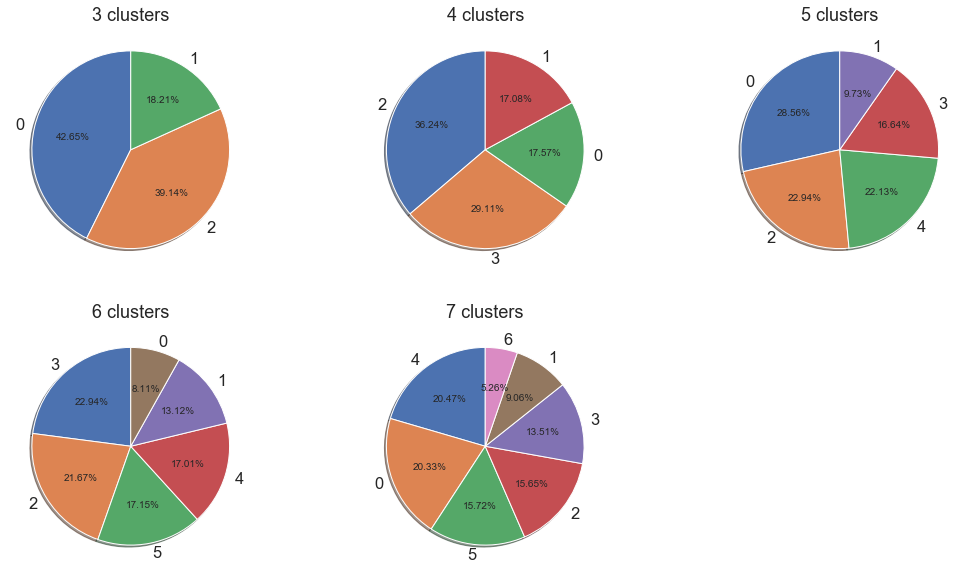

In [116]:
customer_history_df['cluster_3'] = cluster_centers[3]['labels']
customer_history_df['cluster_4'] = cluster_centers[4]['labels']
customer_history_df['cluster_5'] = cluster_centers[5]['labels']
customer_history_df['cluster_6'] = cluster_centers[6]['labels']
customer_history_df['cluster_7'] = cluster_centers[7]['labels']

fig = plt.figure(figsize=(18,10))
f1 = fig.add_subplot(231)
market = customer_history_df.cluster_3.value_counts()
g = plt.pie(market,labels=market.index,autopct='%1.2f%%',shadow=True,startangle=90)
plt.title('3 clusters')
f2 = fig.add_subplot(232)
market = customer_history_df.cluster_4.value_counts()
g = plt.pie(market,labels=market.index,autopct='%1.2f%%',shadow=True,startangle=90)
plt.title('4 clusters')
f3 = fig.add_subplot(233)
market = customer_history_df.cluster_5.value_counts()
g = plt.pie(market,labels=market.index,autopct='%1.2f%%',shadow=True,startangle=90)
plt.title('5 clusters')
f4 = fig.add_subplot(234)
market = customer_history_df.cluster_6.value_counts()
g = plt.pie(market,labels=market.index,autopct='%1.2f%%',shadow=True,startangle=90)
plt.title('6 clusters')
f5 = fig.add_subplot(235)
market = customer_history_df.cluster_7.value_counts()
g = plt.pie(market,labels=market.index,autopct='%1.2f%%',shadow=True,startangle=90)
plt.title('7 clusters')
plt.show()

In [121]:
customer_history_df.groupby(['RFMscore_level','cluster_4'])['CustomerID'].count()     #对比两种不同的分类方式得出的结果

RFMscore_level  cluster_4
1               0              13
                1             601
                3              66
2               0             407
                1             134
                3             479
3               0             340
                1               6
                2             223
                3             562
4               0               2
                2            1349
                3             156
Name: CustomerID, dtype: int64

In [124]:
customer_history_df.groupby(['RFMscore_level', 'cluster_7'])['CustomerID'].count()

RFMscore_level  cluster_7
1               1            350
                3             26
                5            100
                6            204
2               0             49
                1             43
                2             95
                3            449
                5            360
                6             24
3               0            454
                2            354
                3            111
                4             11
                5            201
4               0            379
                2            230
                4            877
                5             21
Name: CustomerID, dtype: int64

In [125]:
customer_history_df.groupby(['cluster_4','RFMscore_level'])['CustomerID'].count()     #交换两种分类方法的顺序

cluster_4  RFMscore_level
0          1                   13
           2                  407
           3                  340
           4                    2
1          1                  601
           2                  134
           3                    6
2          3                  223
           4                 1349
3          1                   66
           2                  479
           3                  562
           4                  156
Name: CustomerID, dtype: int64

In [126]:
customer_history_df.groupby(['cluster_7','RFMscore_level'])['CustomerID'].count()

cluster_7  RFMscore_level
0          2                  49
           3                 454
           4                 379
1          1                 350
           2                  43
2          2                  95
           3                 354
           4                 230
3          1                  26
           2                 449
           3                 111
4          3                  11
           4                 877
5          1                 100
           2                 360
           3                 201
           4                  21
6          1                 204
           2                  24
Name: CustomerID, dtype: int64

In [ ]:
#可加入更多的feature进行分类

### DecisionTree on RFM

In [127]:
segmented_rfm.head()

CustomerID  recency  frequency  monetary  r_quantiles  f_quantiles  \
0      12346    326.0          1  77183.60            4            4   
1      12347      2.0          7   4310.00            1            1   
2      12348     75.0          4   1797.24            3            2   
3      12349     19.0          1   1757.55            2            4   
4      12350    310.0          1    334.40            4            4   

   m_quantiles  RFMscore RFMscore_level  recency_log  frequency_log  \
0            1       441              4     5.786897       0.000000   
1            1       111              1     0.693147       1.945910   
2            1       321              3     4.317488       1.386294   
3            1       241              3     2.944439       0.000000   
4            3       443              4     5.736572       0.000000   

   monetary_log  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  
0     11.253942          2          3          4          4          5  
1      8.368693          1          1          1          0          1  
2      7.494007          2          3          4          3          5  
3      7.471676          2          0          3          1          3  
4      5.812338          0          2          0          2          4

In [128]:
X = segmented_rfm.iloc[:,[1,2,2]].values
y = segmented_rfm.iloc[:,8].values     #决策树'测评'RFM分类的得分

In [129]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 0)     #分配训练集与测试集

In [130]:
from sklearn.preprocessing import StandardScaler     #训练
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)     #除拟合外，还包括标准化，降维等

In [131]:
from sklearn.tree import DecisionTreeClassifier
classfier = DecisionTreeClassifier(criterion='entropy',random_state=0)
clf_fit = classfier.fit(X_train,y_train)

In [132]:
y_pred = classfier.predict(X_test)

In [133]:
from sklearn.metrics import accuracy_score
print('Accuracy is of decision tree model is ',accuracy_score(y_pred,y_test)*100)

Accuracy is of decision tree model is  93.27188940092167


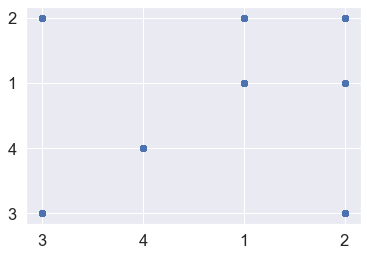

In [134]:
plt.scatter(y_test,y_pred)

In [141]:
segmented_rfm.columns

Index(['CustomerID', 'recency', 'frequency', 'monetary', 'r_quantiles',
       'f_quantiles', 'm_quantiles', 'RFMscore', 'RFMscore_level',
       'recency_log', 'frequency_log', 'monetary_log', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'],
      dtype='object')

In [158]:
X = segmented_rfm.iloc[:,[1,2,3]].values
y = segmented_rfm.iloc[:,16].values     #决策树'测评'k-means++的得分

In [159]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [160]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [161]:
classfier = DecisionTreeClassifier(criterion='entropy',random_state=0)
clf_fit = classfier.fit(X_train,y_train)

In [162]:
y_pred = classfier.predict(X_test)

In [163]:
from sklearn.metrics import accuracy_score
print(f'Accuracy is of decidion tree model is:{accuracy_score(y_pred,y_test)*100}')

Accuracy is of decidion tree model is:70.87557603686636


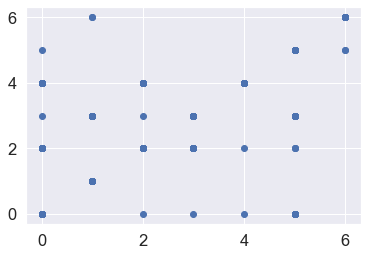

In [164]:
plt.scatter(y_test,y_pred)

In [167]:
for i in range(3,15):
    classfier = DecisionTreeClassifier(criterion='entropy',max_depth=i,random_state=0)
    clf_fit = classfier.fit(X_train,y_train)
    y_pred = classfier.predict(X_test)
    print(f'Accuracy is of tree model is:{accuracy_score(y_pred,y_test)*100}')

Accuracy is of tree model is:71.2442396313364
Accuracy is of tree model is:73.08755760368663
Accuracy is of tree model is:74.83870967741936
Accuracy is of tree model is:76.22119815668202
Accuracy is of tree model is:69.86175115207374
Accuracy is of tree model is:72.25806451612902
Accuracy is of tree model is:70.69124423963133
Accuracy is of tree model is:70.3225806451613
Accuracy is of tree model is:70.50691244239631
Accuracy is of tree model is:70.87557603686636
Accuracy is of tree model is:70.87557603686636
Accuracy is of tree model is:70.87557603686636


### Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression
classfier = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial')
clf_fit = classfier.fit(X_train,y_train)

In [170]:
y_pred = clf_fit.predict(X_test)
print(f'Accuracy of Logistic Regresion is :{accuracy_score(y_pred,y_test)*100}')

Accuracy of Logistic Regresion is :85.34562211981567


### more features

In [172]:
list_special_code = df_eda[df_eda['StockCode'].str.contains('^[a-zA-Z]+',na=False,regex=Trueue)]['StockCode'].unique()

In [173]:
list_special_code

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [183]:
for code in list_special_code:
    print(f'StockCode:{code}---->products:{df_eda[df_eda.StockCode==code]["Description"].unique()[0]}')

StockCode:POST---->products:POSTAGE
StockCode:C2---->products:CARRIAGE
StockCode:M---->products:Manual
StockCode:BANK CHARGES---->products:Bank Charges
StockCode:PADS---->products:PADS TO MATCH ALL CUSHIONS
StockCode:DOT---->products:DOTCOM POSTAGE


#### 交叉销售，消费趋势，阶段分析……